In [1]:
import os
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import hog, graycomatrix, graycoprops
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import ndimage as ndi

In [2]:
class ImageFeatureExtractor:
    """Class for extracting various texture and shape features from images"""
    
    def __init__(self):
        # Parameters for feature extraction
        self.hog_pixels_per_cell = (8, 8)
        self.hog_cells_per_block = (2, 2)
        self.hog_orientations = 9
        self.glcm_distances = [1, 2, 3]
        self.glcm_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        
        # Gabor filter parameters
        self.gabor_frequencies = [0.05, 0.1, 0.2, 0.3, 0.4]
        self.gabor_orientations = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, 2*np.pi/3, 3*np.pi/4, 5*np.pi/6]
        self.gabor_sigma = 3.0
        self.gabor_bandwidth = 1.5
    
    def preprocess_image(self, image, size=(256, 256)):
        """Preprocess image to standardize size and format"""
        if len(image.shape) == 2:  # If grayscale
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:  # If RGBA
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        
        # Resize image
        image = cv2.resize(image, size)
        return image
    
    def extract_color_texture_features(self, image):
        """Extract BCTU, RCTU and PCTU color texture features"""
        # Convert to different color spaces
        hsv_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lab_img = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        
        # Extract color channel statistics (mean, std, skewness, kurtosis)
        features = []
        
        # Process each color space
        for img in [image, hsv_img, lab_img]:
            for channel in range(3):
                channel_data = img[:,:,channel].flatten()
                mean = np.mean(channel_data)
                std = np.std(channel_data)
                skewness = np.mean(((channel_data - mean) / std) ** 3) if std > 0 else 0
                kurtosis = np.mean(((channel_data - mean) / std) ** 4) - 3 if std > 0 else 0
                
                features.extend([mean, std, skewness, kurtosis])
        
        return np.array(features)
    
    def extract_gray_texture_features(self, image):
        """Extract BGTU, RGTU, FGTU gray texture features using GLCM"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Calculate GLCM
        glcm = graycomatrix(gray_image, distances=self.glcm_distances, 
                           angles=self.glcm_angles, levels=256, symmetric=True, normed=True)
        
        # Extract GLCM properties
        contrast = graycoprops(glcm, 'contrast').flatten()
        dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
        homogeneity = graycoprops(glcm, 'homogeneity').flatten()
        energy = graycoprops(glcm, 'energy').flatten()
        correlation = graycoprops(glcm, 'correlation').flatten()
        ASM = graycoprops(glcm, 'ASM').flatten()
        
        # Combine all texture features
        texture_features = np.concatenate([contrast, dissimilarity, homogeneity, 
                                          energy, correlation, ASM])
        
        return texture_features
    
    def gabor_kernel(self, frequency, theta):
        """Create a Gabor filter kernel with specified parameters"""
        sigma_x = self.gabor_sigma
        sigma_y = self.gabor_sigma / self.gabor_bandwidth
        
        # Bounding box
        nstds = 3  # Number of standard deviations
        xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
        xmax = np.ceil(max(1, xmax))
        ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
        ymax = np.ceil(max(1, ymax))
        
        # Create a meshgrid for the kernel
        x, y = np.meshgrid(np.arange(-xmax, xmax + 1), np.arange(-ymax, ymax + 1))
        
        # Rotation
        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)
        
        # Calculate Gabor function
        gb = np.exp(-.5 * (x_theta**2 / sigma_x**2 + y_theta**2 / sigma_y**2)) * np.cos(2 * np.pi * frequency * x_theta)
        
        return gb
    
    def extract_gabor_features(self, image):
        """Extract texture features using Gabor filters at multiple scales and orientations"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = gray_image.astype(np.float32) / 255.0  # Normalize to [0, 1]
        
        gabor_features = []
        
        for frequency in self.gabor_frequencies:
            for theta in self.gabor_orientations:
                # Generate Gabor kernel
                kernel = self.gabor_kernel(frequency, theta)
                
                # Apply filter
                filtered_img = ndi.convolve(gray_image, kernel, mode='wrap')
                
                # Extract statistics from filtered image
                mean = np.mean(filtered_img)
                std = np.std(filtered_img)
                energy = np.sum(filtered_img**2)
                
                gabor_features.extend([mean, std, energy])
        
        return np.array(gabor_features)
    
    def extract_shape_features(self, image):
        """Extract HOG and image moments shape features"""
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Extract HOG features
        hog_features = hog(gray_image, orientations=self.hog_orientations,
                          pixels_per_cell=self.hog_pixels_per_cell,
                          cells_per_block=self.hog_cells_per_block, visualize=False)
        
        # Calculate image moments
        moments = cv2.moments(gray_image)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        # Log transform Hu moments (common practice since values can be small)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        
        # Combine shape features
        shape_features = np.concatenate([hog_features, hu_moments])
        
        return shape_features
    
    def extract_all_features(self, image):
        """Extract all features from an image"""
        processed_image = self.preprocess_image(image)
        
        color_features = self.extract_color_texture_features(processed_image)
        gray_features = self.extract_gray_texture_features(processed_image)
        gabor_features = self.extract_gabor_features(processed_image)
        shape_features = self.extract_shape_features(processed_image)
        
        # Combine all features
        all_features = np.concatenate([color_features, gray_features, gabor_features, shape_features])
        
        return all_features

In [3]:
class PSOOptimizer:
    """Particle Swarm Optimization for feature weight optimization"""
    
    def __init__(self, n_dimensions, n_particles=30, max_iter=50):
        self.n_dimensions = n_dimensions
        self.n_particles = n_particles
        self.max_iter = max_iter
        
        # PSO parameters
        self.w = 0.7  # Inertia weight
        self.c1 = 1.5  # Cognitive weight
        self.c2 = 1.5  # Social weight
        
        # Initialize particles and velocities
        self.particles = np.random.uniform(0, 1, (self.n_particles, self.n_dimensions))
        self.velocities = np.zeros((self.n_particles, self.n_dimensions))
        
        # Normalize weights to sum to 1
        self.particles = self.particles / np.sum(self.particles, axis=1)[:, np.newaxis]
        
        # Initialize best positions
        self.pbest = self.particles.copy()
        self.pbest_fitness = np.zeros(self.n_particles) + np.inf
        
        self.gbest = None
        self.gbest_fitness = np.inf
    
    def optimize(self, fitness_function):
        """Run PSO optimization"""
        for iteration in range(self.max_iter):
            # Evaluate fitness for each particle
            for i in range(self.n_particles):
                fitness = fitness_function(self.particles[i])
                
                # Update personal best
                if fitness < self.pbest_fitness[i]:
                    self.pbest_fitness[i] = fitness
                    self.pbest[i] = self.particles[i].copy()
                
                # Update global best
                if fitness < self.gbest_fitness:
                    self.gbest_fitness = fitness
                    self.gbest = self.particles[i].copy()
            
            # Update velocities and positions
            for i in range(self.n_particles):
                r1, r2 = np.random.random(2)
                
                self.velocities[i] = (self.w * self.velocities[i] + 
                                     self.c1 * r1 * (self.pbest[i] - self.particles[i]) +
                                     self.c2 * r2 * (self.gbest - self.particles[i]))
                
                self.particles[i] += self.velocities[i]
                
                # Ensure weights are non-negative
                self.particles[i] = np.maximum(0, self.particles[i])
                
                # Normalize weights to sum to 1
                if np.sum(self.particles[i]) > 0:
                    self.particles[i] = self.particles[i] / np.sum(self.particles[i])
            
            # Print progress
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, Best fitness: {self.gbest_fitness:.6f}")
        
        return self.gbest, self.gbest_fitness

In [4]:
class CGATSERFOPSO_Simplified:
    """Simplified implementation of CGATSERFOPSO method (skipping covariance matrix)"""
    
    def __init__(self):
        self.feature_extractor = ImageFeatureExtractor()
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.feature_weights = None
    
    def load_image_dataset(self, database_path, img_list, label_list, extensions=('.jpg', '.jpeg', '.png')):
        """Load images from database directory"""
        images = []
        labels = []
        image_paths = []
        
        for img_rel_path, label in zip(img_list, label_list):
            if img_rel_path.lower().endswith(extensions):
                full_path = os.path.join(database_path, img_rel_path)
                try:
                    image = io.imread(full_path)
                    images.append(image)
                    labels.append(label)
                    image_paths.append(full_path)
                except Exception as e:
                    print(f"Error loading image {full_path}: {e}")
                    
        return images, labels, image_paths
    
    def extract_features_from_dataset(self, images):
        """Extract features from all images in the dataset"""
        all_features = []
        
        for i, image in enumerate(images):
            if i % 10 == 0:
                print(f"Extracting features from image {i+1}/{len(images)}")
            
            features = self.feature_extractor.extract_all_features(image)
            all_features.append(features)
        
        return np.array(all_features)
    
    def train_rf_classifier(self, features, labels):
        """Train the Random Forest classifier"""
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=0.2, random_state=42
        )
        
        self.rf_classifier.fit(X_train, y_train)
        
        # Evaluate classifier
        y_pred = self.rf_classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"RF Classifier Accuracy: {accuracy:.4f}")

        # Calculate feature importances from RF
        feature_importances = self.rf_classifier.feature_importances_
        return feature_importances
    
    def optimize_weights_with_pso(self, features, labels):
        """Optimize feature weights using PSO"""
        # Group features by class
        unique_labels = np.unique(labels)
        class_features = {label: [] for label in unique_labels}
        
        for i, label in enumerate(labels):
            class_features[label].append(features[i])
        
        # Convert lists to arrays
        for label in unique_labels:
            class_features[label] = np.array(class_features[label])
        
        # Calculate class means
        class_means = {label: np.mean(class_features[label], axis=0) for label in unique_labels}
        
        # Calculate overall mean
        overall_mean = np.mean(features, axis=0)
        
        # Define fitness function for PSO (minimize within-class scatter / between-class scatter)
        def fitness_function(weights):
            # Apply weights to features
            weighted_class_means = {label: weights * class_means[label] for label in unique_labels}
            weighted_overall_mean = weights * overall_mean
            
            # Calculate between-class scatter
            between_scatter = 0
            for label in unique_labels:
                diff = weighted_class_means[label] - weighted_overall_mean
                between_scatter += len(class_features[label]) * np.sum(diff**2)
            
            # Calculate within-class scatter
            within_scatter = 0
            for label in unique_labels:
                for feature in class_features[label]:
                    weighted_feature = weights * feature
                    diff = weighted_feature - weighted_class_means[label]
                    within_scatter += np.sum(diff**2)
            
            # Avoid division by zero
            if between_scatter == 0:
                return np.inf
            
            # Return ratio (minimize within / between)
            return within_scatter / between_scatter
        
        # Initialize PSO
        pso = PSOOptimizer(n_dimensions=features.shape[1], n_particles=20, max_iter=50)
        
        # Run optimization
        best_weights, best_fitness = pso.optimize(fitness_function)
        
        self.feature_weights = best_weights
        return best_weights
    
    def calculate_weighted_distance(self, query_features, database_features):
        """Calculate weighted Euclidean distance between query and database features"""
        distances = []
        
        for db_feature in database_features:
            # Apply feature weights
            weighted_query = self.feature_weights * query_features
            weighted_db = self.feature_weights * db_feature
            
            # Calculate Euclidean distance (instead of Mahalanobis)
            dist = euclidean(weighted_query, weighted_db)
            distances.append(dist)
        
        return np.array(distances)
    
    def retrieve_similar_images(self, query_image, database_images, database_paths, top_k=10):
        """Retrieve top-k similar images using weighted distance"""
        # Extract features from query image
        query_features = self.feature_extractor.extract_all_features(query_image)
        
        # Extract features from database if not already extracted
        if not hasattr(self, 'database_features'):
            self.database_features = self.extract_features_from_dataset(database_images)
        
        # Calculate distances
        distances = self.calculate_weighted_distance(query_features, self.database_features)
        
        # Get indices of top-k similar images
        top_indices = np.argsort(distances)[:top_k]
        
        # Return paths and distances of similar images
        similar_images = [database_paths[i] for i in top_indices]
        similar_distances = distances[top_indices]
        
        return similar_images, similar_distances
    
    def train(self, database_path, img_list, label_list):
        """Train the simplified CGATSERFOPSO model (skip covariance matrix)"""
        print("Loading image dataset...")
        images, labels, image_paths = self.load_image_dataset(database_path, img_list, label_list)
        
        print(f"Loaded {len(images)} images from {len(np.unique(labels))} classes")
        
        print("Extracting features from database images...")
        features = self.extract_features_from_dataset(images)
        
        print("Training RF classifier...")
        feature_importances = self.train_rf_classifier(features, labels)
        
        print("Optimizing feature weights with PSO...")
        self.optimize_weights_with_pso(features, labels)
        
        # Store database features and paths for later retrieval
        self.database_features = features
        self.database_paths = image_paths
        self.database_labels = labels
        
        print("Training complete!")
    
    def query(self, query_image_path, top_k=10):
        """Query the system with a new image"""
        query_image = io.imread(query_image_path)
        
        similar_images, distances = self.retrieve_similar_images(
            query_image, 
            [io.imread(path) for path in self.database_paths], 
            self.database_paths, 
            top_k
        )
        
        return similar_images, distances
    
    def save_model(self, model_path):
        """Save the trained model for later use"""
        model_data = {
            'feature_weights': self.feature_weights,
            'database_features': self.database_features,
            'database_paths': self.database_paths,
            'database_labels': self.database_labels,
            'rf_classifier': self.rf_classifier
        }
        
        with open(model_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {model_path}")
    
    def load_model(self, model_path):
        """Load a previously trained model"""
        try:
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.feature_weights = model_data['feature_weights']
            self.database_features = model_data['database_features']
            self.database_paths = model_data['database_paths']
            self.database_labels = model_data['database_labels']
            self.rf_classifier = model_data['rf_classifier']
            
            print(f"Model loaded from {model_path}")
            return True
        except Exception as e:
            print(f"Error loading model: {e}")
            return False
    
    def visualize_results(self, query_image_path, similar_images, distances):
        """Visualize query results"""
        query_image = io.imread(query_image_path)
        
        plt.figure(figsize=(15, 8))
        
        # Display query image
        plt.subplot(3, 4, 1)
        plt.imshow(query_image)
        plt.title("Query Image")
        plt.axis('off')
        
        # Display similar images
        for i, (img_path, dist) in enumerate(zip(similar_images, distances)):
            if i >= 11:  # Display at most 11 similar images (1 query + 11 = 12 total)
                break
            
            img = io.imread(img_path)
            plt.subplot(3, 4, i + 2)
            plt.imshow(img)
            plt.title(f"Sim #{i+1}, Dist: {dist:.4f}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
    def visualize_gabor_filters(self):
        """Visualize the Gabor filters used for feature extraction"""
        n_frequencies = len(self.feature_extractor.gabor_frequencies)
        n_orientations = len(self.feature_extractor.gabor_orientations)
        
        plt.figure(figsize=(15, 10))
        plt.suptitle("Gabor Filter Bank", fontsize=16)
        
        for i, freq in enumerate(self.feature_extractor.gabor_frequencies):
            for j, theta in enumerate(self.feature_extractor.gabor_orientations):
                kernel = self.feature_extractor.gabor_kernel(freq, theta)
                plt.subplot(n_frequencies, n_orientations, i*n_orientations + j + 1)
                plt.imshow(kernel, cmap='gray')
                plt.axis('off')
                plt.title(f"f={freq:.2f}, θ={theta:.2f}")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    
    def visualize_gabor_responses(self, image_path):
        """Visualize Gabor filter responses for a given image"""
        image = io.imread(image_path)
        image = self.feature_extractor.preprocess_image(image)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = gray_image.astype(np.float32) / 255.0
        
        n_frequencies = len(self.feature_extractor.gabor_frequencies)
        n_orientations = len(self.feature_extractor.gabor_orientations)
        
        plt.figure(figsize=(20, 12))
        plt.suptitle("Gabor Filter Responses", fontsize=16)
        
        # Original image
        plt.subplot(n_frequencies + 1, n_orientations, 1)
        plt.imshow(gray_image, cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Filter responses
        for i, freq in enumerate(self.feature_extractor.gabor_frequencies):
            for j, theta in enumerate(self.feature_extractor.gabor_orientations):
                kernel = self.feature_extractor.gabor_kernel(freq, theta)
                filtered_img = ndi.convolve(gray_image, kernel, mode='wrap')
                
                plt.subplot(n_frequencies + 1, n_orientations, (i+1)*n_orientations + j + 1)
                plt.imshow(np.abs(filtered_img), cmap='viridis')
                plt.axis('off')
                plt.title(f"f={freq:.2f}, θ={theta:.2f}")
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

Loading image dataset...
Loaded 20000 images from 1310 classes
Extracting features from database images...
Extracting features from image 1/20000
Extracting features from image 11/20000
Extracting features from image 21/20000
Extracting features from image 31/20000
Extracting features from image 41/20000
Extracting features from image 51/20000
Extracting features from image 61/20000
Extracting features from image 71/20000
Extracting features from image 81/20000
Extracting features from image 91/20000
Extracting features from image 101/20000
Extracting features from image 111/20000
Extracting features from image 121/20000
Extracting features from image 131/20000
Extracting features from image 141/20000
Extracting features from image 151/20000
Extracting features from image 161/20000
Extracting features from image 171/20000
Extracting features from image 181/20000
Extracting features from image 191/20000
Extracting features from image 201/20000
Extracting features from image 211/20000
Ex

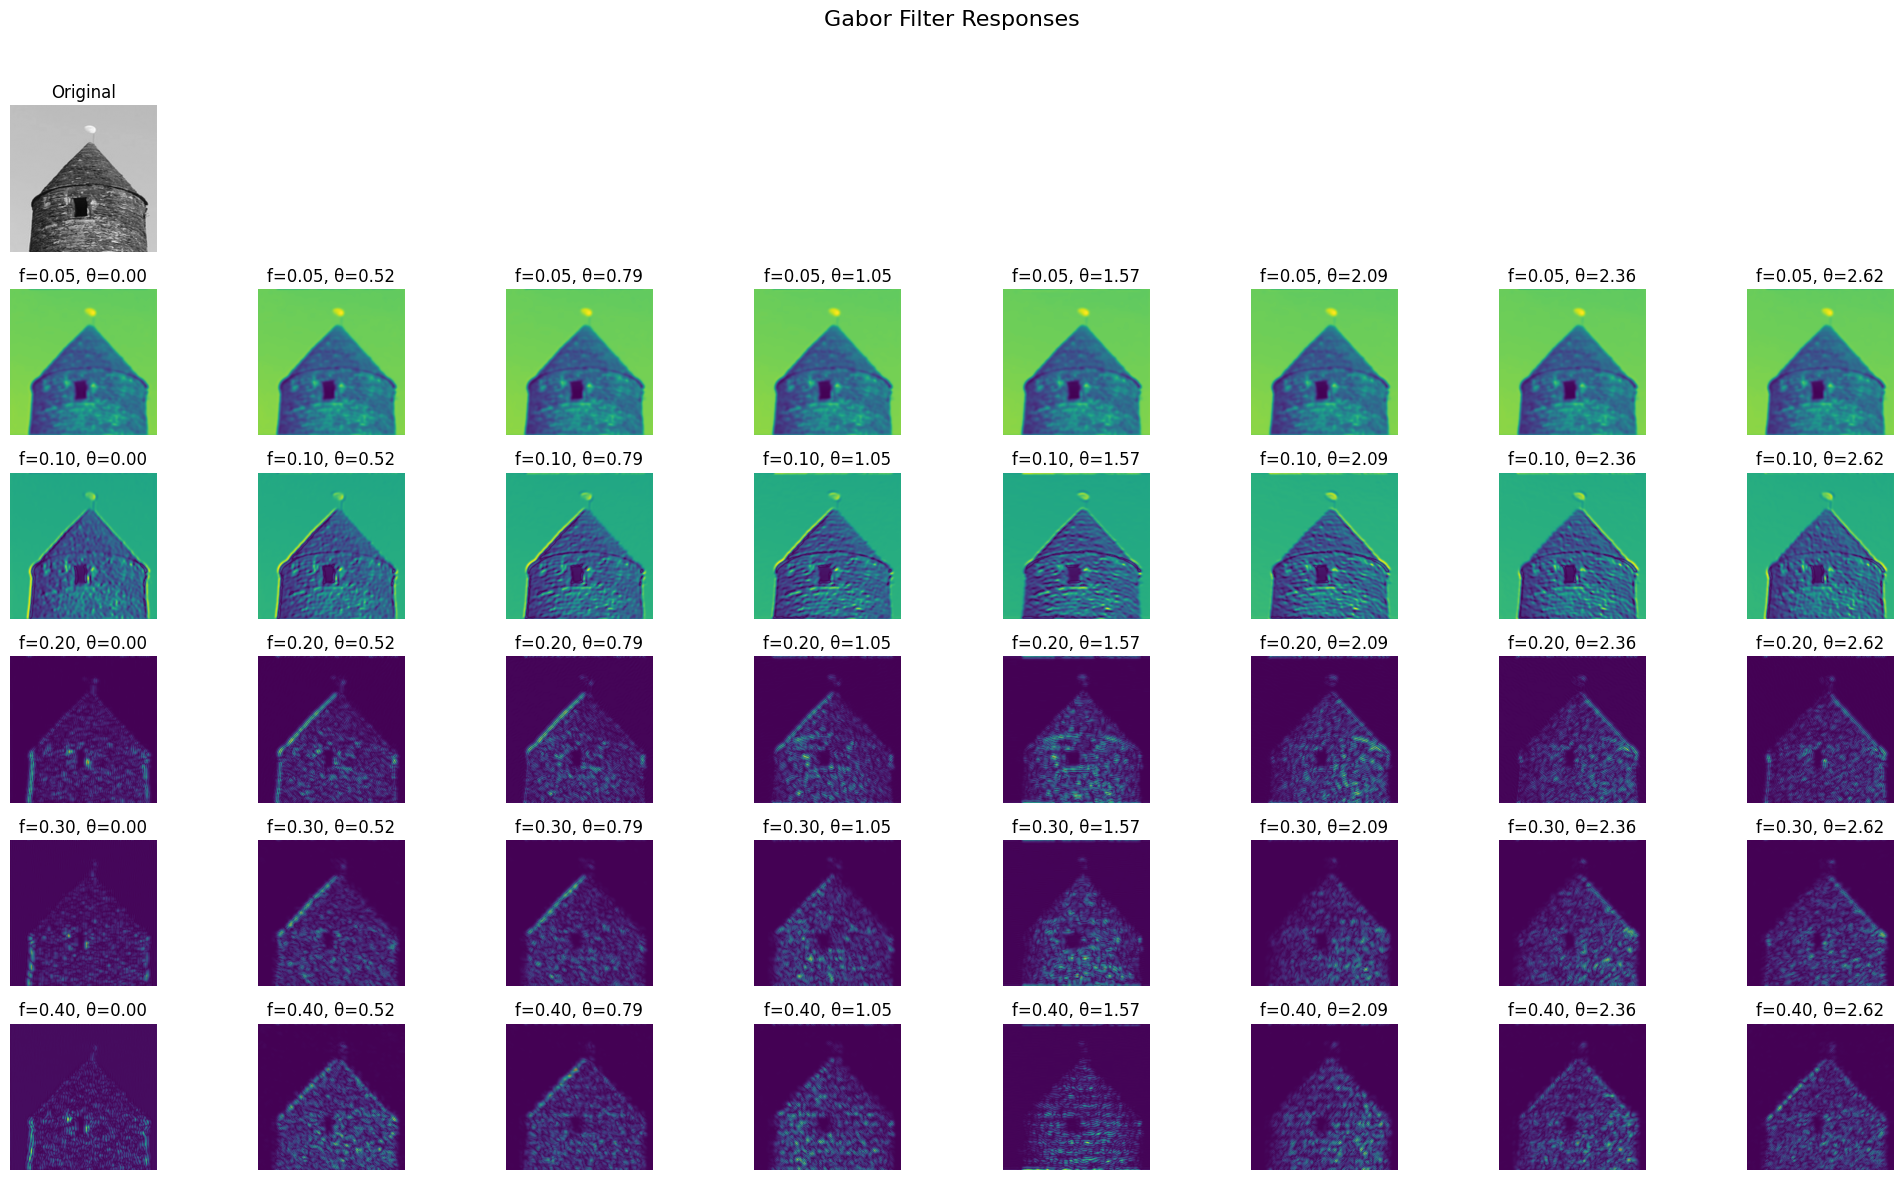

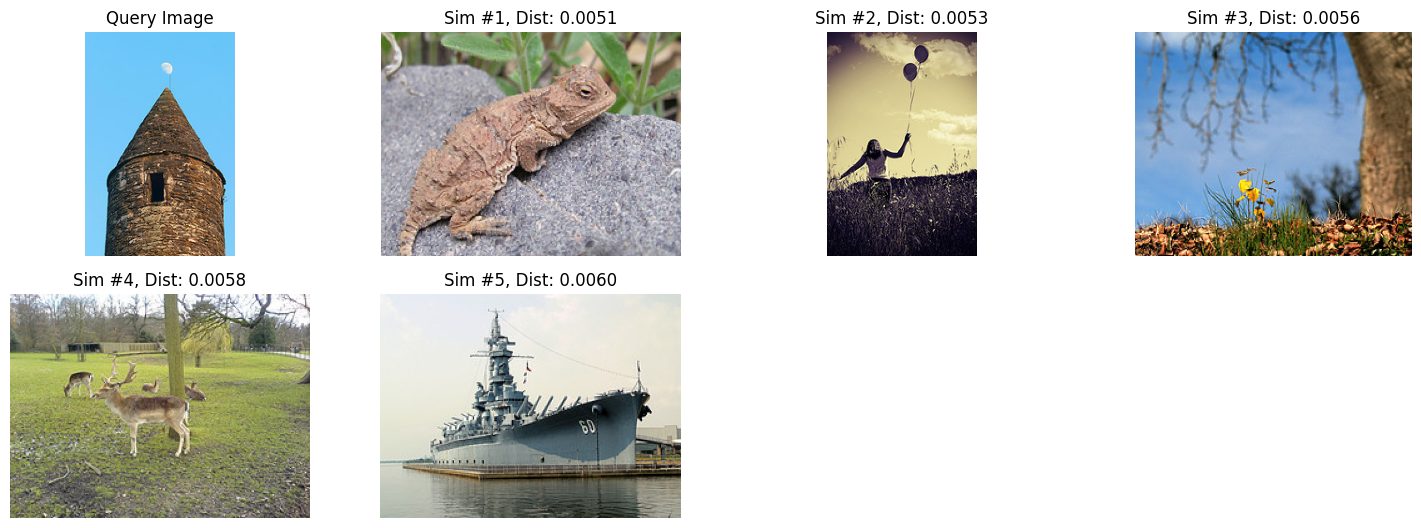

Demonstration complete!


In [5]:
if __name__ == "__main__":
    # Initialize the simplified CGATSERFOPSO system
    system = CGATSERFOPSO_Simplified()

    # Train the system (replace with your dataset path)
    database_path = "nuswide/NUS-WIDE"

    # get the list of first ten files from database_img.txt
    # get the list of labels of first ten files from  database_label.txt
    # File paths (update these if the files are in a different location)
    img_file_path = 'nuswide/NUS-WIDE/database_img.txt'
    label_file_path = 'nuswide/NUS-WIDE/database_label.txt'
    
    # Read first 10 lines from each file
    with open(img_file_path, 'r') as f_img, open(label_file_path, 'r') as f_label:
        img_list = [line.strip() for _, line in zip(range(20000), f_img)]
        label_list = [line.strip() for _, line in zip(range(20000), f_label)]
    
    # If you have a real dataset, uncomment these lines
    system.train(database_path, img_list, label_list)
    
    # # For demonstration, let's create a simple synthetic dataset
    # print("Creating synthetic dataset for demonstration...")
    
    # # Create a directory for synthetic data
    # os.makedirs("synthetic_data/class1", exist_ok=True)
    # os.makedirs("synthetic_data/class2", exist_ok=True)
    
    # # Generate synthetic images
    # for i in range(10):
    #     # Class 1: Images with more red
    #     img1 = np.ones((100, 100, 3), dtype=np.uint8) * 128
    #     img1[:, :, 0] = np.random.randint(200, 256, (100, 100))  # Red channel
    #     cv2.imwrite(f"synthetic_data/class1/image_{i}.jpg", img1)
        
    #     # Class 2: Images with more blue
    #     img2 = np.ones((100, 100, 3), dtype=np.uint8) * 128
    #     img2[:, :, 2] = np.random.randint(200, 256, (100, 100))  # Blue channel
    #     cv2.imwrite(f"synthetic_data/class2/image_{i}.jpg", img2)
    
    # # Create a query image (more similar to class 1)
    # query_img = np.ones((100, 100, 3), dtype=np.uint8) * 128
    # query_img[:, :, 0] = np.random.randint(180, 220, (100, 100))  # Red channel
    # cv2.imwrite("synthetic_data/query.jpg", query_img)
    
    # # Train on synthetic data
    # features, labels, image_paths = system.train("synthetic_data")
    
    # # Save the model
    system.save_model("cgatserfopso_model_with_gabor.pkl")

    # Visualize Gabor filters
    # system.visualize_gabor_filters()

    # Example query with visualization
    query_image_path = "nuswide/NUS-WIDE/images/0697_2269243447.jpg"
    system.visualize_gabor_responses(query_image_path)
    
    # # Query with synthetic image
    similar_images, distances = system.query("nuswide/NUS-WIDE/images/0697_2269243447.jpg", top_k=5)
    system.visualize_results("nuswide/NUS-WIDE/images/0697_2269243447.jpg", similar_images, distances)
    # Helicopter: nuswide/NUS-WIDE/images/0001_52826591.jpg
    print("Demonstration complete!")
    
    # Example of command-line interface
    import argparse
    
    def run_cli():
        parser = argparse.ArgumentParser(description="CGATSERFOPSO Simplified Training")
        parser.add_argument("--train", help="Path to training dataset")
        parser.add_argument("--query", help="Path to query image")
        parser.add_argument("--model", help="Path to save/load model")
        parser.add_argument("--top_k", type=int, default=10, help="Number of similar images to retrieve")
        
        args = parser.parse_args()
        
        system = CGATSERFOPSO_Simplified()
        
        if args.train:
            # Train model
            system.train(args.train)
            
            if args.model:
                system.save_model(args.model)
        
        if args.query:
            if not args.train and args.model:
                # Load model if not training
                with open(args.model, 'rb') as f:
                    model_data = pickle.load(f)
                
                system.feature_weights = model_data['feature_weights']
                system.database_features = model_data['database_features']
                system.database_paths = model_data['database_paths']
                system.database_labels = model_data['database_labels']
                system.rf_classifier = model_data['rf_classifier']
            
            # Query with image
            similar_images, distances = system.query(args.query, args.top_k)
            system.visualize_results(args.query, similar_images, distances)
    
    # Uncomment to enable CLI
    # run_cli()